In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("Python Spark regression example").config("config.option", "value").getOrCreate()

In [5]:
df = spark.read.csv("gs://1230ll/train_data-011.csv",inferSchema=True,sep='|',header=True)

In [6]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- uid: integer (nullable = true)
 |-- task_id: integer (nullable = true)
 |-- adv_id: integer (nullable = true)
 |-- creat_type_cd: integer (nullable = true)
 |-- adv_prim_id: integer (nullable = true)
 |-- dev_id: integer (nullable = true)
 |-- inter_type_cd: integer (nullable = true)
 |-- slot_id: integer (nullable = true)
 |-- spread_app_id: integer (nullable = true)
 |-- tags: integer (nullable = true)
 |-- app_first_class: integer (nullable = true)
 |-- app_second_class: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- city_rank: integer (nullable = true)
 |-- device_name: integer (nullable = true)
 |-- device_size: integer (nullable = true)
 |-- career: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- net_type: integer (nullable = true)
 |-- residence: integer (nullable = true)
 |-- his_app_size: integer (nullable = true)
 |-- his_on_shelf_time: integer (nulla

In [7]:
type(df)


pyspark.sql.dataframe.DataFrame

In [8]:
from pyspark.sql.functions import *
from pyspark.sql.functions import when, count, col
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
# we should handle the missing values by imputation unless too many of them are emtpy
# na.drop() method is not recommended for avoiding biased

+-----+---+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+------------------------+---------------------------+---------+----+
|label|uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_onlinerate|communication_avgonline_30d|indu_name|pt_d|
+-----+---+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+---

In [9]:
import missingno as msno
msno.bar(df.toPandas())

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
import matplotlib.pyplot as plt

In [11]:
import pandas as pd

In [12]:
df1=df.toPandas()

In [13]:
shuffled_df = df1.sample(frac=1,random_state=4)

In [14]:
fraud_df = shuffled_df.loc[shuffled_df['label'] == 1]
non_fraud_df=shuffled_df.loc[shuffled_df['label']== 0].sample(n=32000,random_state=42)
df2 = pd.concat([fraud_df, non_fraud_df])

In [15]:
import seaborn as sns

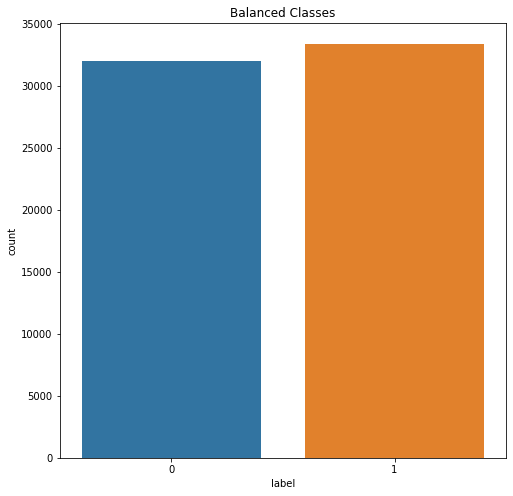

In [16]:
plt.figure(figsize=(8, 8))
sns.countplot('label', data=df2)

plt.title('Balanced Classes')

plt.show()

In [62]:
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df3 = sqlContext.createDataFrame(df2)

In [63]:
file=df3.drop('communication_onlinerate')
file.show(10)

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+---------------------------+---------+----+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_avgonline_30d|indu_name|pt_d|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+--

In [49]:
from pyspark.ml.feature import VectorAssembler

In [64]:
###Select the columns involved in the calculation
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=[
     'creat_type_cd',
     'inter_type_cd',
     'tags',
     'app_first_class',
     'app_second_class',
     'age',
    'city',
    'city_rank',
    "device_name",
    "device_size",
    'career',
    'gender',
    'net_type',
    'residence',
    'his_app_size',
    'his_on_shelf_time',
    'app_score','emui_dev',
    'list_time','device_price',
    'up_life_duration',
    'up_membership_grade',
    'membership_life_duration',
    'consume_purchase',
    'communication_avgonline_30d',
    'indu_name',
    'pt_d'
 ], outputCol='features')
 
assembled_data=assemble.transform(file)
 
assembled_data.show(2)
assembled_data.select('features').show()

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+---------------------------+---------+----+--------------------+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_avgonline_30d|indu_name|pt_d|            features|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---

In [102]:
from pyspark.ml.feature import StandardScaler
 
scale=StandardScaler(inputCol='features',outputCol='standardized')
 
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
 
data_scale_output.show(2)

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+---------------------------+---------+----+--------------------+--------------------+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_avgonline_30d|indu_name|pt_d|            features|        standardized|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+------------------------+---------------------------+---------+----+--------------------+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_onlinerate|communication_avgonline_30d|indu_name|pt_d|            features|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-----

+--------------------+
|            features|
+--------------------+
|[7.0,5.0,39.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,40.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,39.0,4.0...|
|[8.0,5.0,41.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[6.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,37.0,4.0...|
|[7.0,5.0,40.0,4.0...|
+--------------------+
only showing top 20 rows



In [65]:
assembled_data.select('label').show()

+-----+
|label|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows



In [55]:
from pyspark.ml import Pipeline

In [67]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

In [68]:
log = LogisticRegression(featuresCol='features',labelCol='label')
rf = RandomForestClassifier(featuresCol='features',labelCol='label')

In [69]:
pipelinelog = Pipeline(stages=[log])
pipelinerf = Pipeline(stages=[rf])

In [70]:
# random split with a seed number to reproduce the results
train_data, test_data = assembled_data.randomSplit([0.8,.2],100)

In [71]:
fit_model_log = pipelinelog.fit(train_data)
fit_model_rf = pipelinerf.fit(train_data)

In [72]:
train_log_results = fit_model_log.transform(train_data)
test_log_results = fit_model_log.transform(test_data)


train_rf_results = fit_model_rf.transform(train_data)
test_rf_results = fit_model_rf.transform(test_data)


In [73]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [74]:
AUC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
Accu_evaluator = MulticlassClassificationEvaluator()
Accu_evaluator.setPredictionCol('prediction')
Accu_evaluator.setLabelCol('label')

MulticlassClassificationEvaluator_9962b6a5a7eb

In [76]:
test_log_results.select('label','prediction').show()
test_rf_results.select('label','prediction').show()


+-----+----------+
|label|prediction|
+-----+----------+
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 20 rows



In [77]:
AUC_log_test = AUC.evaluate(test_log_results)
AUC_log_train = AUC.evaluate(train_log_results)


AUC_rf_test = AUC.evaluate(test_rf_results)
AUC_rf_train = AUC.evaluate(train_rf_results)




Accu_log_test = Accu_evaluator.evaluate(test_log_results, {Accu_evaluator.metricName: "accuracy"})
Accu_log_train = Accu_evaluator.evaluate(train_log_results, {Accu_evaluator.metricName: "accuracy"})




Accu_rf_test = Accu_evaluator.evaluate(test_rf_results, {Accu_evaluator.metricName: "accuracy"})
Accu_rf_train = Accu_evaluator.evaluate(train_rf_results, {Accu_evaluator.metricName: "accuracy"})

In [78]:
print("Test AUC", AUC_log_test)
print("\n")
print("Train AUC", AUC_log_train)

Test AUC 0.5908310756654431


Train AUC 0.5935814652936642


In [79]:
print("Test AUC", AUC_rf_test)
print("\n")
print("Train AUC", AUC_rf_train)

Test AUC 0.6035765088950799


Train AUC 0.6115905031978967


In [80]:
print("Test Accuracy", Accu_log_test)
print("\n")
print("Train Accuracy", Accu_log_train)

Test Accuracy 0.5923513182096873


Train Accuracy 0.59489608801956


In [81]:
print("Test Accuracy", Accu_rf_test)
print("\n")
print("Train Accuracy", Accu_rf_train)

Test Accuracy 0.6040006131207848


Train Accuracy 0.6119154951100244


In [82]:
fit_model_rf.stages[-1].featureImportances

SparseVector(27, {0: 0.0192, 1: 0.0372, 2: 0.0752, 3: 0.0798, 4: 0.072, 5: 0.2253, 6: 0.0028, 7: 0.0036, 8: 0.0027, 9: 0.002, 10: 0.0518, 11: 0.0009, 12: 0.0133, 13: 0.01, 14: 0.1381, 15: 0.0613, 16: 0.0818, 17: 0.0048, 18: 0.0044, 19: 0.061, 20: 0.0128, 21: 0.0002, 23: 0.0007, 24: 0.0092, 25: 0.0299, 26: 0.0})

In [85]:
input_cols_Label= ['creat_type_cd',
     'inter_type_cd',
     'tags',
     'app_first_class',
     'app_second_class',
     'age',
    'city',
    'city_rank',
    "device_name",
    "device_size",
    'career',
    'gender',
    'net_type',
    'residence',
    'his_app_size',
    'his_on_shelf_time',
    'app_score','emui_dev',
    'list_time','device_price',
    'up_life_duration',
    'up_membership_grade',
    'membership_life_duration',
    'consume_purchase',
    'communication_avgonline_30d',
    'indu_name']

In [86]:
input_cols_Label

['creat_type_cd',
 'inter_type_cd',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_avgonline_30d',
 'indu_name']

In [87]:
df4=fit_model_rf.transform(train_data)

In [88]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [89]:

ExtractFeatureImp(fit_model_rf.stages[-1].featureImportances, df4, "features")

,idx,name,score
5,5,age,0.225270
14,14,his_app_size,0.138072
16,16,app_score,0.081831
3,3,app_first_class,0.079753
2,2,tags,0.075222
4,4,app_second_class,0.072049
15,15,his_on_shelf_time,0.061269
19,19,device_price,0.061026
10,10,career,0.051819
1,1,inter_type_cd,0.037174


In [92]:
features=ExtractFeatureImp(fit_model_rf.stages[-1].featureImportances, df4, "features")

features=features[features.score>0.05].iloc[:,1].tolist()
vars=features+['label']
vars

['age',
 'his_app_size',
 'app_score',
 'app_first_class',
 'tags',
 'app_second_class',
 'his_on_shelf_time',
 'device_price',
 'career',
 'label']

In [93]:
train_selected=fit_model_rf.transform(train_data).select(vars)
test_selected=fit_model_rf.transform(test_data).select(vars)

In [94]:
# we don't need to apply whole of pipeline just the last step which training the model is enough
assembler = VectorAssembler(inputCols= features, outputCol="features")
datatrain = assembler.transform(train_selected)
datatest = assembler.transform(test_selected)

log_reg = LogisticRegression(featuresCol='features',labelCol='label')

fit_new = log_reg.fit(datatrain)

In [95]:
train_new_results = fit_new.transform(datatrain)
test_new_results = fit_new.transform(datatest)

In [98]:
AUC_test_new = AUC.evaluate(train_new_results)
AUC_train_new = AUC.evaluate(test_new_results)

Accu_test_new = Accu_evaluator.evaluate(test_new_results, {Accu_evaluator.metricName: "accuracy"})
Accu_train_new = Accu_evaluator.evaluate(train_new_results, {Accu_evaluator.metricName: "accuracy"})

In [101]:

print("Train AUC & feature selection", AUC_train_new)
print("\n")

print("Train & feature selection", Accu_train_new)

Train AUC & feature selection 0.5737649964249674


Train & feature selection 0.5769025061124694


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pip install pyecharts

In [ ]:
from pyecharts.charts import Bar